## Basics

In [60]:
y.shape

(6, 2, 3)

In [102]:
@njit(cache=True)
def interp_multidim(points, x,y):
    points = np.asarray(points)
    x = np.asarray(x)

    # Initialize the array for the results
    z = np.zeros_like(points)

    # Compute indices for each point in the flattened array
    for i in np.ndindex(y.shape[1:]):
        p = points[i]
        if p < x[0]:
            z[i] = y[(0,) + i]
        elif p > x[-1]:
            z[i] = y[(-1,) + i]
        else:
            ind = np.searchsorted(x, p) - 1
            x0 = x[ind]
            x1 = x[ind+1]
            y0 = y[(ind,) + i]
            y1 = y[(ind+1,) + i]
            z[i] = y0 + (p - x0) * (y1 - y0) / (x1 - x0)

    return z

In [103]:
# Example usage
x = np.array([0, 1, 2, 3, 4, 5])

points = np.array([
    [-0.5, 1.5, 2.5],  # Points in the first dimension
    [3.5, 4.5, 5.5]   # Points in the second dimension
])
y = np.array([
    [[0, 1, 2], [10, 11, 12]],  # y-values at x=0
    [[1, 2, 3], [11, 12, 13]],  # y-values at x=1
    [[2, 3, 4], [12, 13, 14]],  # y-values at x=2
    [[3, 4, 5], [13, 14, 15]],  # y-values at x=3
    [[4, 5, 6], [14, 15, 16]],  # y-values at x=4
    [[5, 6, 7], [15, 16, 17]]   # y-values at x=5
])

zz = index_interp(points, x,y)

print(zz)

[[ 0.   2.5  4.5]
 [13.5 15.5 17. ]]


In [69]:
for i in np.ndindex(y.shape[1:]):
    print(y[zz[i],i[0],i[1]])

0
2
4
13
15
17


In [63]:
zz.shape

(2, 3)

In [65]:
y.shape[1:]

(2, 3)

In [48]:
@njit(cache=True)
def index_interp(points,x):
    points = np.asarray(points)
    x = np.asarray(x)
    indices = np.searchsorted(x, points) - 1
    indices[points < x[0]] = 0
    indices[points > x[-1]] = -1
    return indices

In [44]:
zz

array([0, 3], dtype=int64)

In [45]:
import numpy as np

# Example 1D x-coordinates
x = np.array([0, 1, 2, 3, 4, 5])

# Example 3D y-values: Shape (len(x), 2, 3)
# Dimensions are: len(x) for x-coordinates, 2 for dim1, 3 for dim2
y = np.array([
    [[0, 1, 2], [10, 11, 12]],  # y-values at x=0
    [[1, 2, 3], [11, 12, 13]],  # y-values at x=1
    [[2, 3, 4], [12, 13, 14]],  # y-values at x=2
    [[3, 4, 5], [13, 14, 15]],  # y-values at x=3
    [[4, 5, 6], [14, 15, 16]],  # y-values at x=4
    [[5, 6, 7], [15, 16, 17]]   # y-values at x=5
])

# Example 2D points where interpolation is needed: Shape (2, 3)
points = np.array([
    [0.5, 1.5, 2.5],  # Points in the first dimension
    [3.5, 4.5, 5.5]   # Points in the second dimension
])

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt)

    # Check if the key exists in the saved results
    if key in all_results:
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_hmq_sep.pkl", "rb") as file:
    all_results = pickle.load(file)

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)

In [5]:
# HMQ
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']

profiler = cProfile.Profile()
profiler.enable()
#(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()
profiler.disable()

# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
stats.print_stats()
#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
ceiln1.shape

(10, 10, 10, 10)

In [2]:
EJderiv0.shape

(10, 10, 10, 10)

In [ ]:
# HMQ Separations

results = get_results_for_p(p,all_results)
if results is None:
    mwc_hmq_sd_J = objects['mwc_hmq_sd_J']
    mwc_hmq_sd_W = objects['mwc_hmq_sd_W']
else:
    mwc_hmq_sd_J = results['Ji']
    mwc_hmq_sd_W = results['W1i']

(mwc_hmq_sd_J,mwc_hmq_sd_W,mwc_hmq_sd_Wstar,mwc_hmq_sd_sep,mwc_hmq_sd_n0,mwc_hmq_sd_n1)=mwc_hmq.J_sep_dir()

objects['mwc_hmq_sd_J'] = mwc_hmq_sd_J
objects['mwc_hmq_sd_W'] = mwc_hmq_sd_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
# Retrieve the objects
#mwch_J = objects['mwch_J']
#mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J()
#(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_sd_J,mwch_sd_W,mwch_sd_Wstar,mwch_sd_sep,mwch_sd_n0,mwch_sd_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [6]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
profiler = cProfile.Profile()
profiler.enable()
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()
profiler.disable()

# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
stats.print_stats()


Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
n0_star borders 0.0 0.0
Errors: 0.16341430140551638 2.676345181240897 1.6827731562978465 3.2479757098313526 1
Errors: 0.0 2.676345181240897 1.6827731562978465 3.2479757098313526 1
n0_star borders 0.0 0.0
EJinv 190.12936834985388
EJderiv 191.3852663882363
EJinv diff 1j 2s: 0.11444870338153229
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 197.97794249660134
EJderiv 187.6974055219416
EJinv diff 1j 2s: 0.06753570117959587
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 200.56789904940098
EJderiv 184.09000835374087
EJinv diff 1j 2s: 0.08208829700904398
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 200.0874382529701
EJderiv 180.56131930511378
EJinv diff 1j 2s: 0.10859632037070745
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 197.84255563002674
EJderiv 177.10962106813002
EJinv diff 1j 2s: 0.12135566268369491
EJinv diff 1 sen: nan
EJi

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:350: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:]/pc_star[:,0,1,:] - EJderiv[:,0,1,:]) / EJderiv[:,0,1,:])))
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:351: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:]/pc_star[:,0,s,:] - EJderiv[:,0,s,:]) / EJderiv[:,0,s,:])))


n0_star borders 0.0 4.0
Errors: 0.07541156039317848 0.00023638047195832313 2.54196184351674 0.0016998013501674063 1
EJinv 178.64178752426167
EJderiv 160.94846448589803
EJinv diff 1j 2s: 0.11191014785179641
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 174.59271660867802
EJderiv 157.92468997420744
EJinv diff 1j 2s: 0.1058333686151024
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 170.625284994737
EJderiv 154.96688976166476
EJinv diff 1j 2s: 0.09959835794938476
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 166.7545556977712
EJderiv 152.07362437702383
EJinv diff 1j 2s: 0.09335906783656067
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 162.98745176187305
EJderiv 149.2434857597966
EJinv diff 1j 2s: 0.08720372415104778
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 159.32619643432741
EJderiv 146.47509656719157
EJinv diff 1j 2s: 0.0811812254333029
EJinv diff

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:350: RuntimeWarning: divide by zero encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:]/pc_star[:,0,1,:] - EJderiv[:,0,1,:]) / EJderiv[:,0,1,:])))


n0_star borders 0.0 0.0
EJinv 42.94275523867414
EJderiv 43.611189831064
EJinv diff 1j 2s: 0.07530138546808511
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 42.50220077032974
EJderiv 43.14752146516401
EJinv diff 1j 2s: 0.07422427853290553
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 42.071969786100524
EJderiv 42.69396987999199
EJinv diff 1j 2s: 0.07312984796033827
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 41.651806023380786
EJderiv 42.250314349587406
EJinv diff 1j 2s: 0.07201898747638366
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 41.241460163081506
EJderiv 41.81633896280217
EJinv diff 1j 2s: 0.07089257871645632
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
Errors: 0.008631039597007662 0.000100064795677454 32.5846757629358 2.4884565684140465e-05 1
Errors: 0.0 0.000100064795677454 32.5846757629358 2.4884565684140465e-05 1
EJinv 40.840689621689705
EJ

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:351: RuntimeWarning: divide by zero encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:]/pc_star[:,0,s,:] - EJderiv[:,0,s,:]) / EJderiv[:,0,s,:])))


n0_star borders 0.0 0.0
EJinv 31.360372231439076
EJderiv 31.15365838662564
EJinv diff 1j 2s: 0.02801520787887001
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 31.186098992168105
EJderiv 30.96180449729543
EJinv diff 1j 2s: 0.026983786173194427
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 31.015747769595727
EJderiv 30.774136762902838
EJinv diff 1j 2s: 0.025972826700863542
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 30.84922778014333
EJderiv 30.59056384401098
EJinv diff 1j 2s: 0.024987919569671613
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 30.686450448369303
EJderiv 30.410996394578746
EJinv diff 1j 2s: 0.024030069908061447
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
Errors: 0.0028160386596602495 3.2374991719192714e-05 52.0975389231039 6.810248250513621e-07 1
EJinv 30.527329348527754
EJderiv 30.23534701650736
EJinv diff 1j 2s: 0.023099519367162626
EJ

# Plots

In [ ]:
#Okay, so we've got some inconsistencies:
#CRS lower than everyone
#HMQ and and basic MWC (without allowing for hiring) are the same
#MWC with hiring is higher than the others (despite hiring being too costly)
#wtf?
#Trying mwch without a guess now

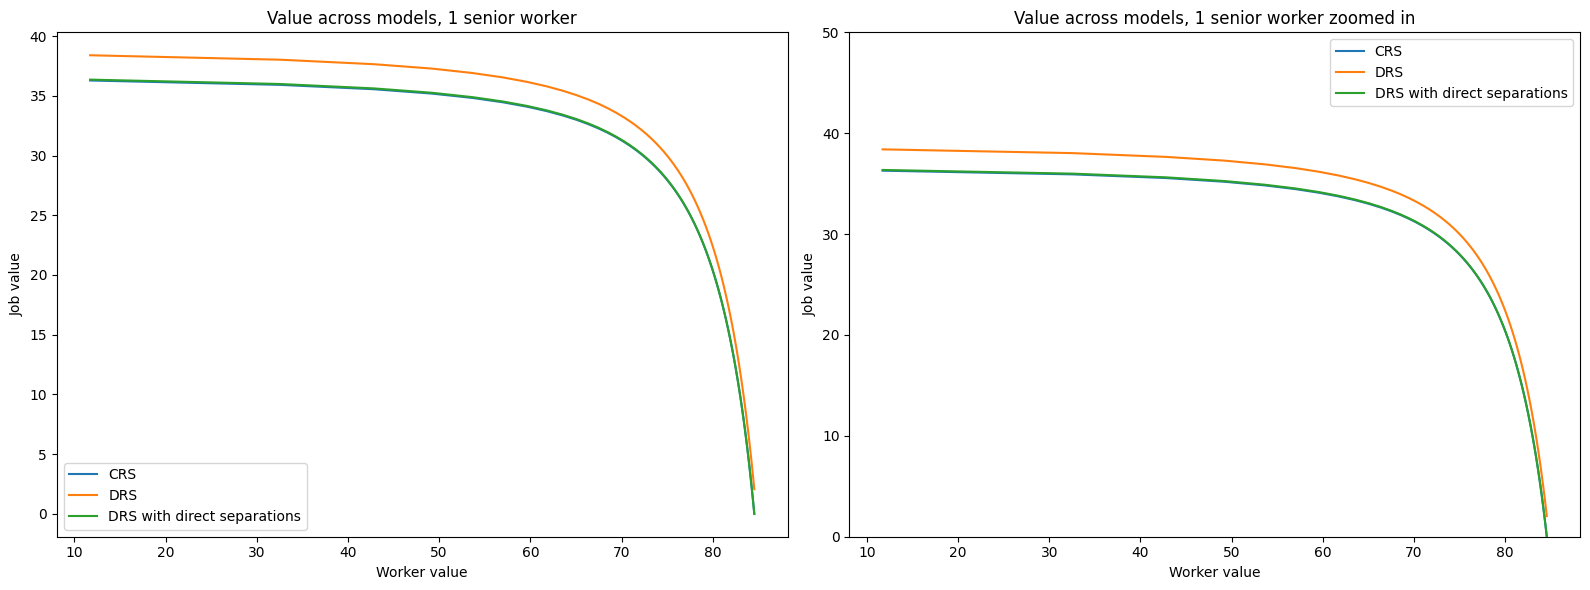

In [8]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_hmq_W[...,5,:],mwc_hmq_J[...,5]/mwc_hmq.N_grid1[1],None,None,mwc_W,mwc_J,0)

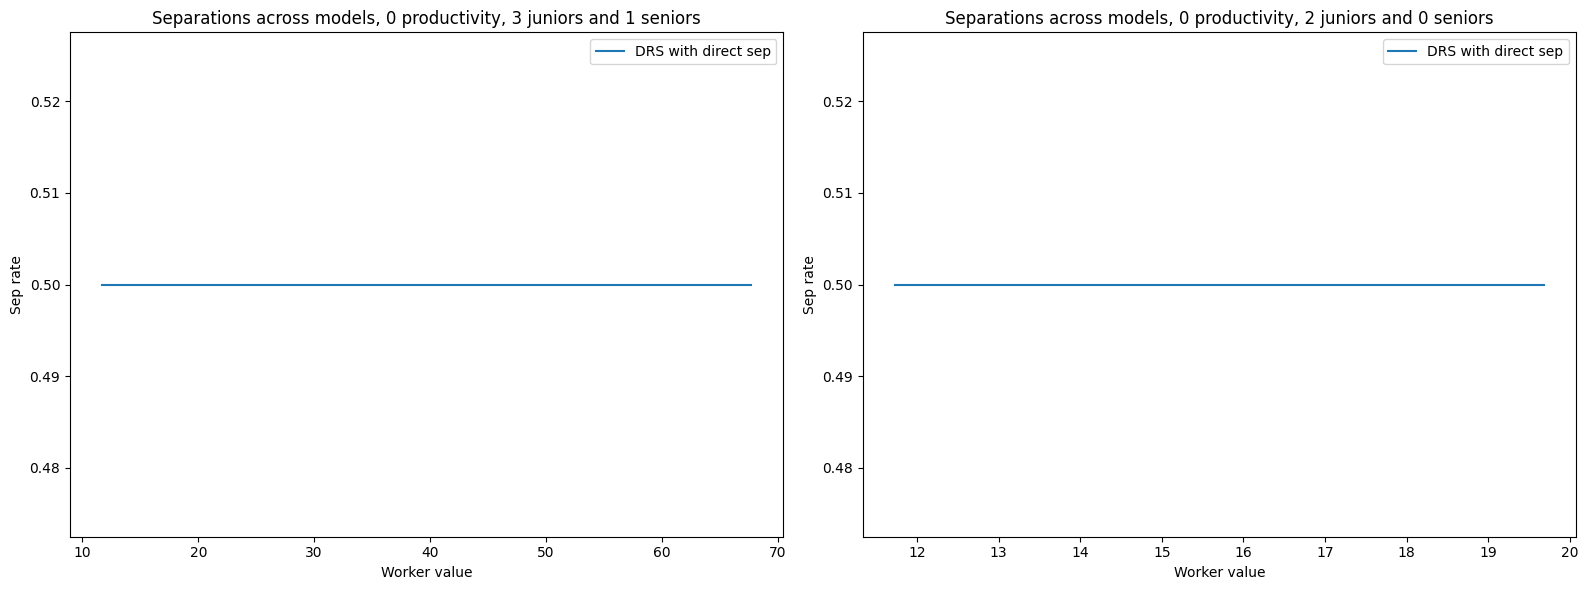

In [17]:
plts.sep(0,p.z_0-1,3,1,2,0,None,None,mwc_hmq_sd_W[...,1,:],mwc_hmq_sd_sep[...,1])

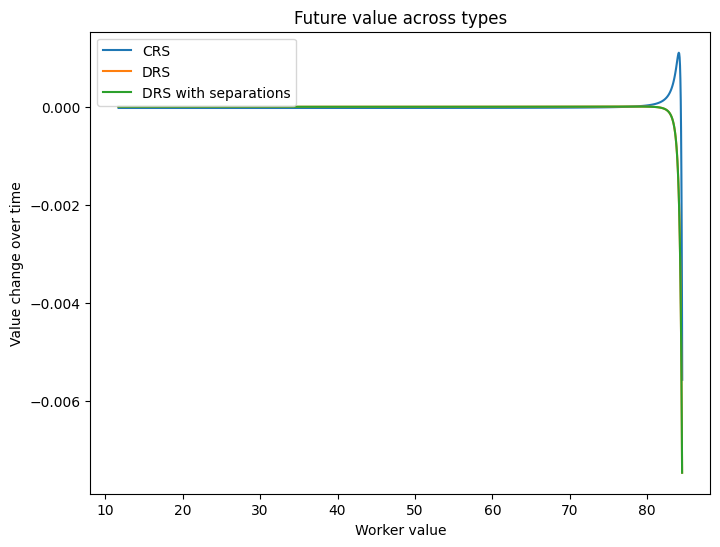

In [19]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_hmq_W[...,0,:],mwc_hmq_Wstar[...,0],mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_Wstar[...,0],mwc_sd_W,mwc_sd_Wstar,0)

In [1]:
plts.ValueComparison(3,1,3,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

NameError: name 'plts' is not defined

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations